In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; warnings.simplefilter('ignore')
import pandas as pd
pd.options.display.max_columns = 12

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy
from abupy import xrange, range

# 打开测试数据环境，与书中的例子数据一致，使用RomDataBu下的df_kl.h5数据
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


In [4]:
from abupy import AbuFactorBuyBreak
from abupy import AbuBenchmark
buy_factors = [{'xd':60, 'class':AbuFactorBuyBreak}, {'xd':42, 'class':AbuFactorBuyBreak}]
benchmark = AbuBenchmark()




In [5]:
from abupy import EMarketSourceType, EMarketSourceType
from abupy import AbuPickTimeWorker, AbuCapital, AbuKLManager
abupy.env.g_market_source = EMarketSourceType.E_MARKET_SOURCE_sn_us
abupy.env.disable_example_env_ipython()

captial = AbuCapital(1000000, benchmark)
kl_pd_manager = AbuKLManager(benchmark, captial)
kl_pd = kl_pd_manager.get_pick_time_kl_pd('usFUTU')
abu_worker = AbuPickTimeWorker(captial, kl_pd, benchmark, buy_factors, None)
%time abu_worker.fit()

disable example env


CPU times: user 124 ms, sys: 285 µs, total: 124 ms
Wall time: 125 ms


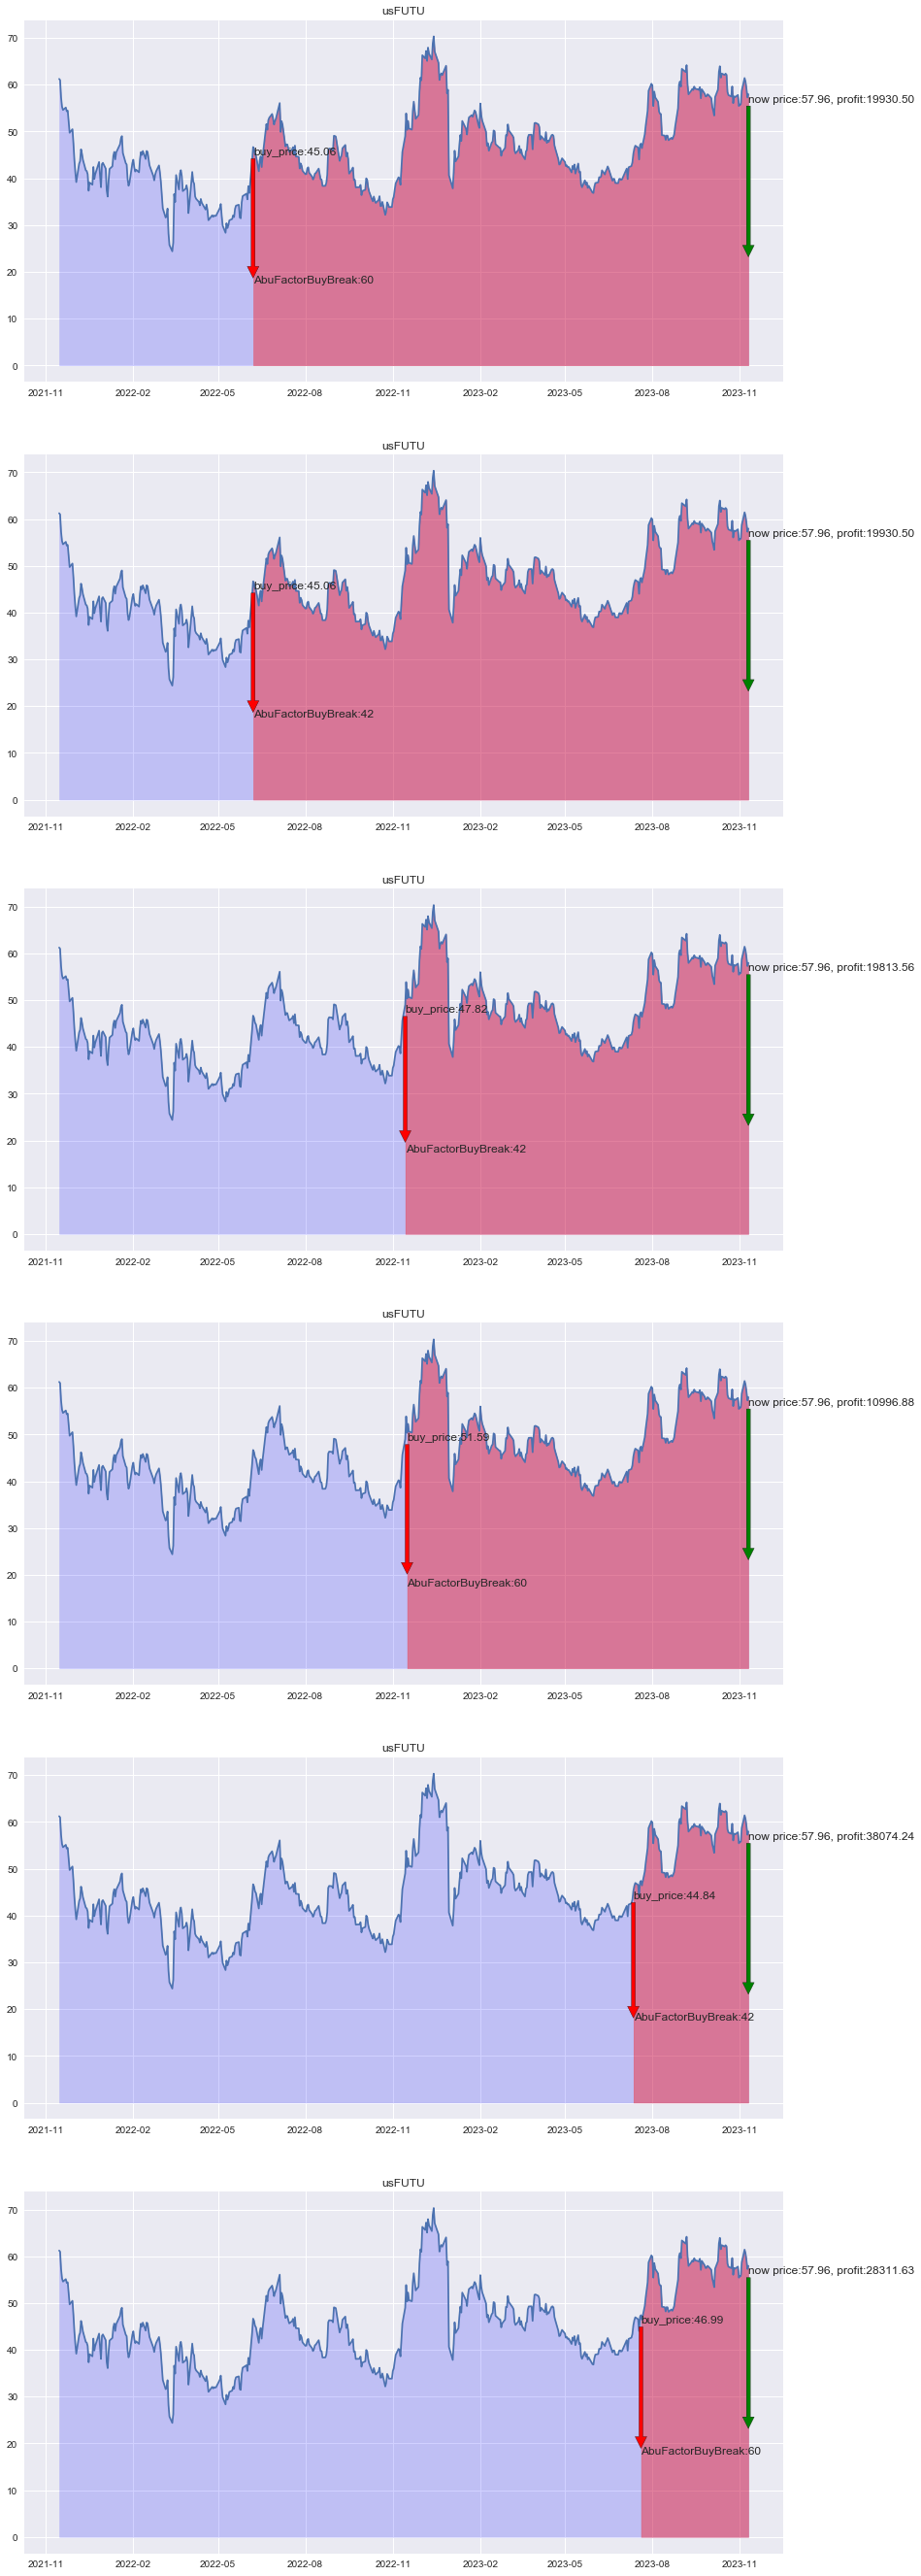

In [6]:
from abupy import ABuTradeProxy
orders_pd , action_pd, _ = ABuTradeProxy.trade_summary(abu_worker.orders, kl_pd, draw=True)

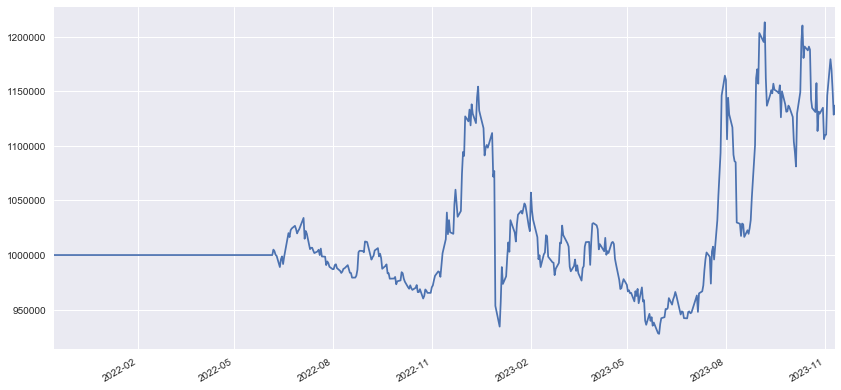

In [9]:
from abupy import ABuTradeExecute
ABuTradeExecute.apply_action_to_capital(captial, action_pd, kl_pd_manager)
captial.capital_pd.capital_blance.plot()

### 8.1.2 卖出因子的实现

In [11]:
from abupy import AbuFactorSellBreak
sell_factor = {'xd': 120, 'class':AbuFactorSellBreak}


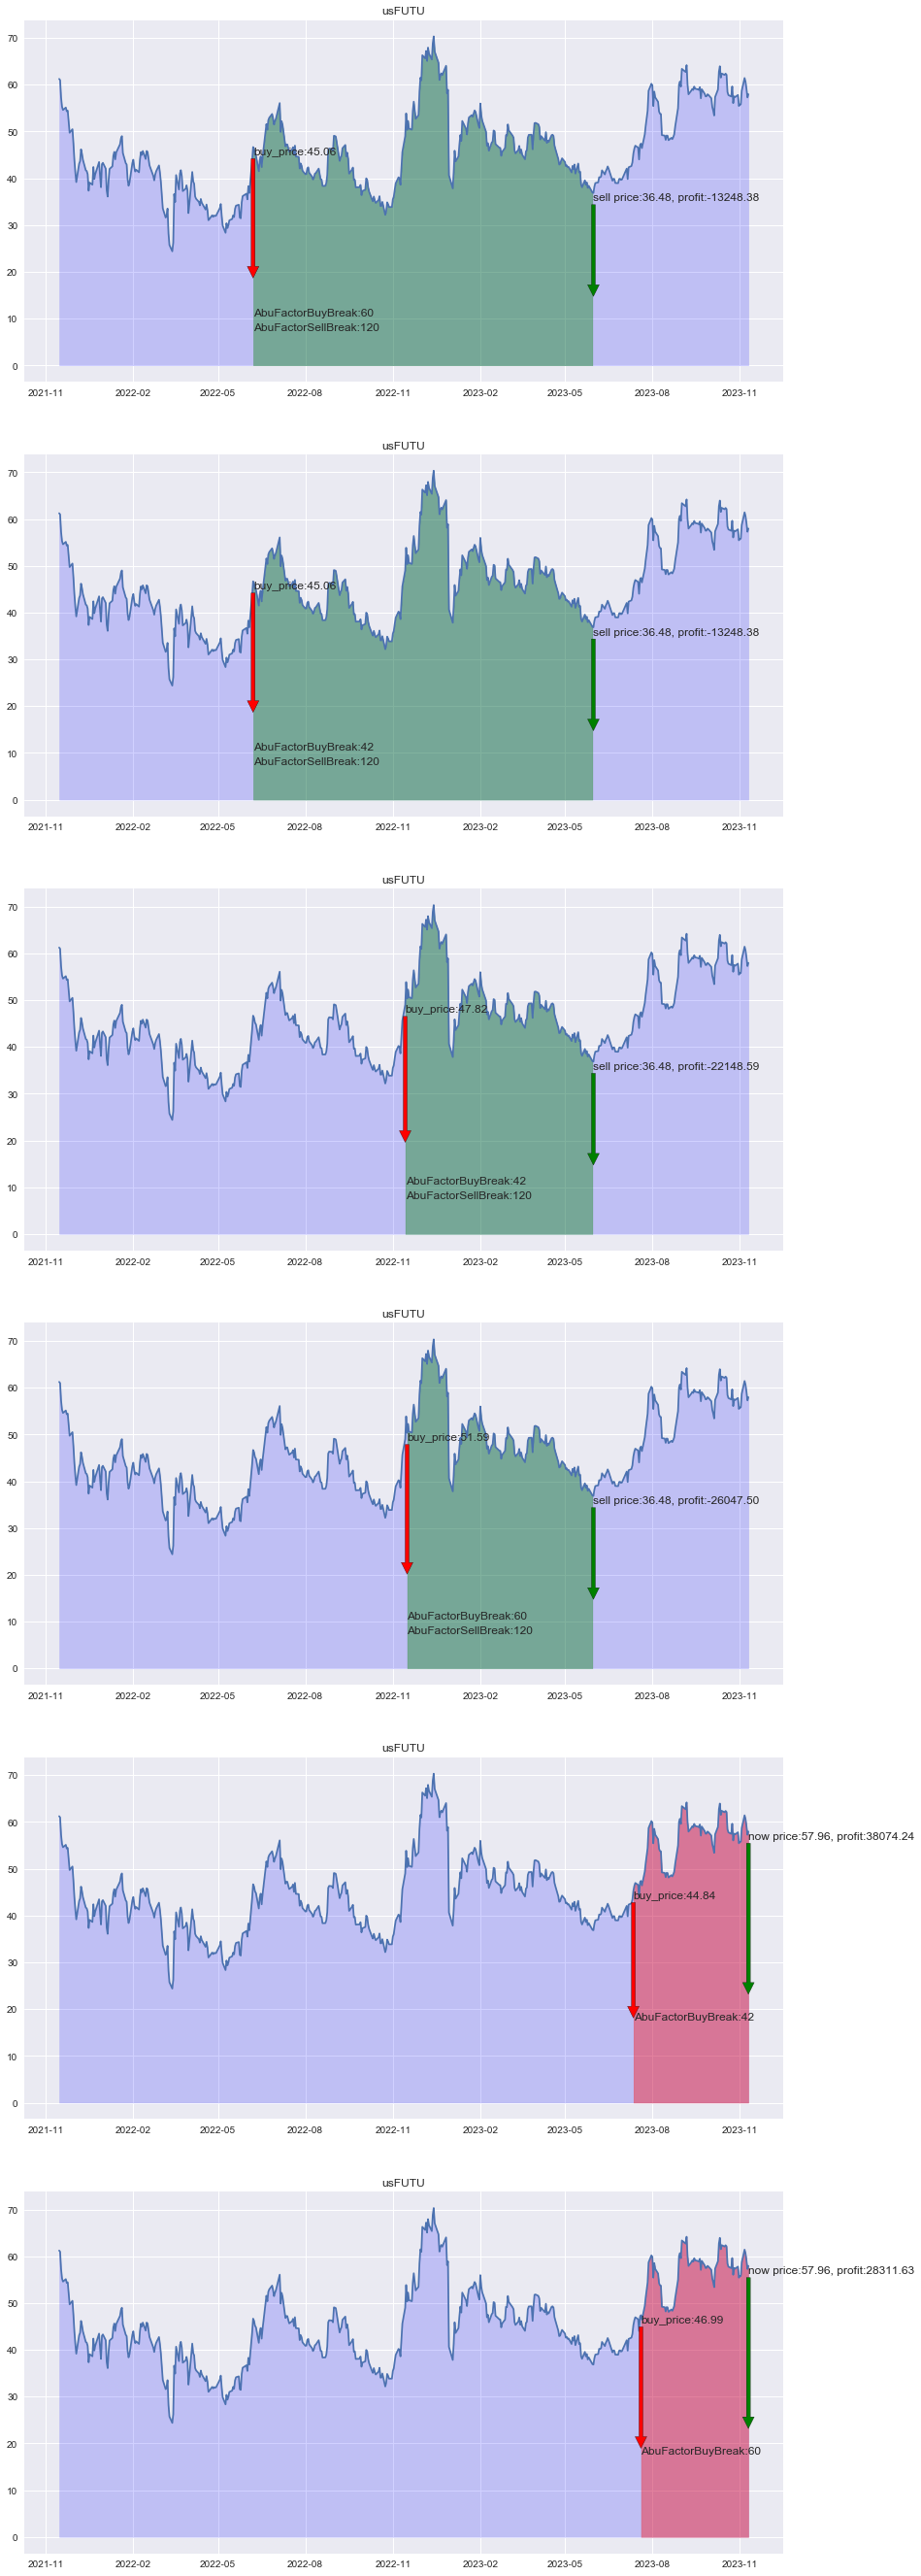

In [13]:
from abupy import ABuPickTimeExecute
sell_factors = [sell_factor]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usFUTU'], benchmark
                                                                        , buy_factors, sell_factors, capital, show=True)

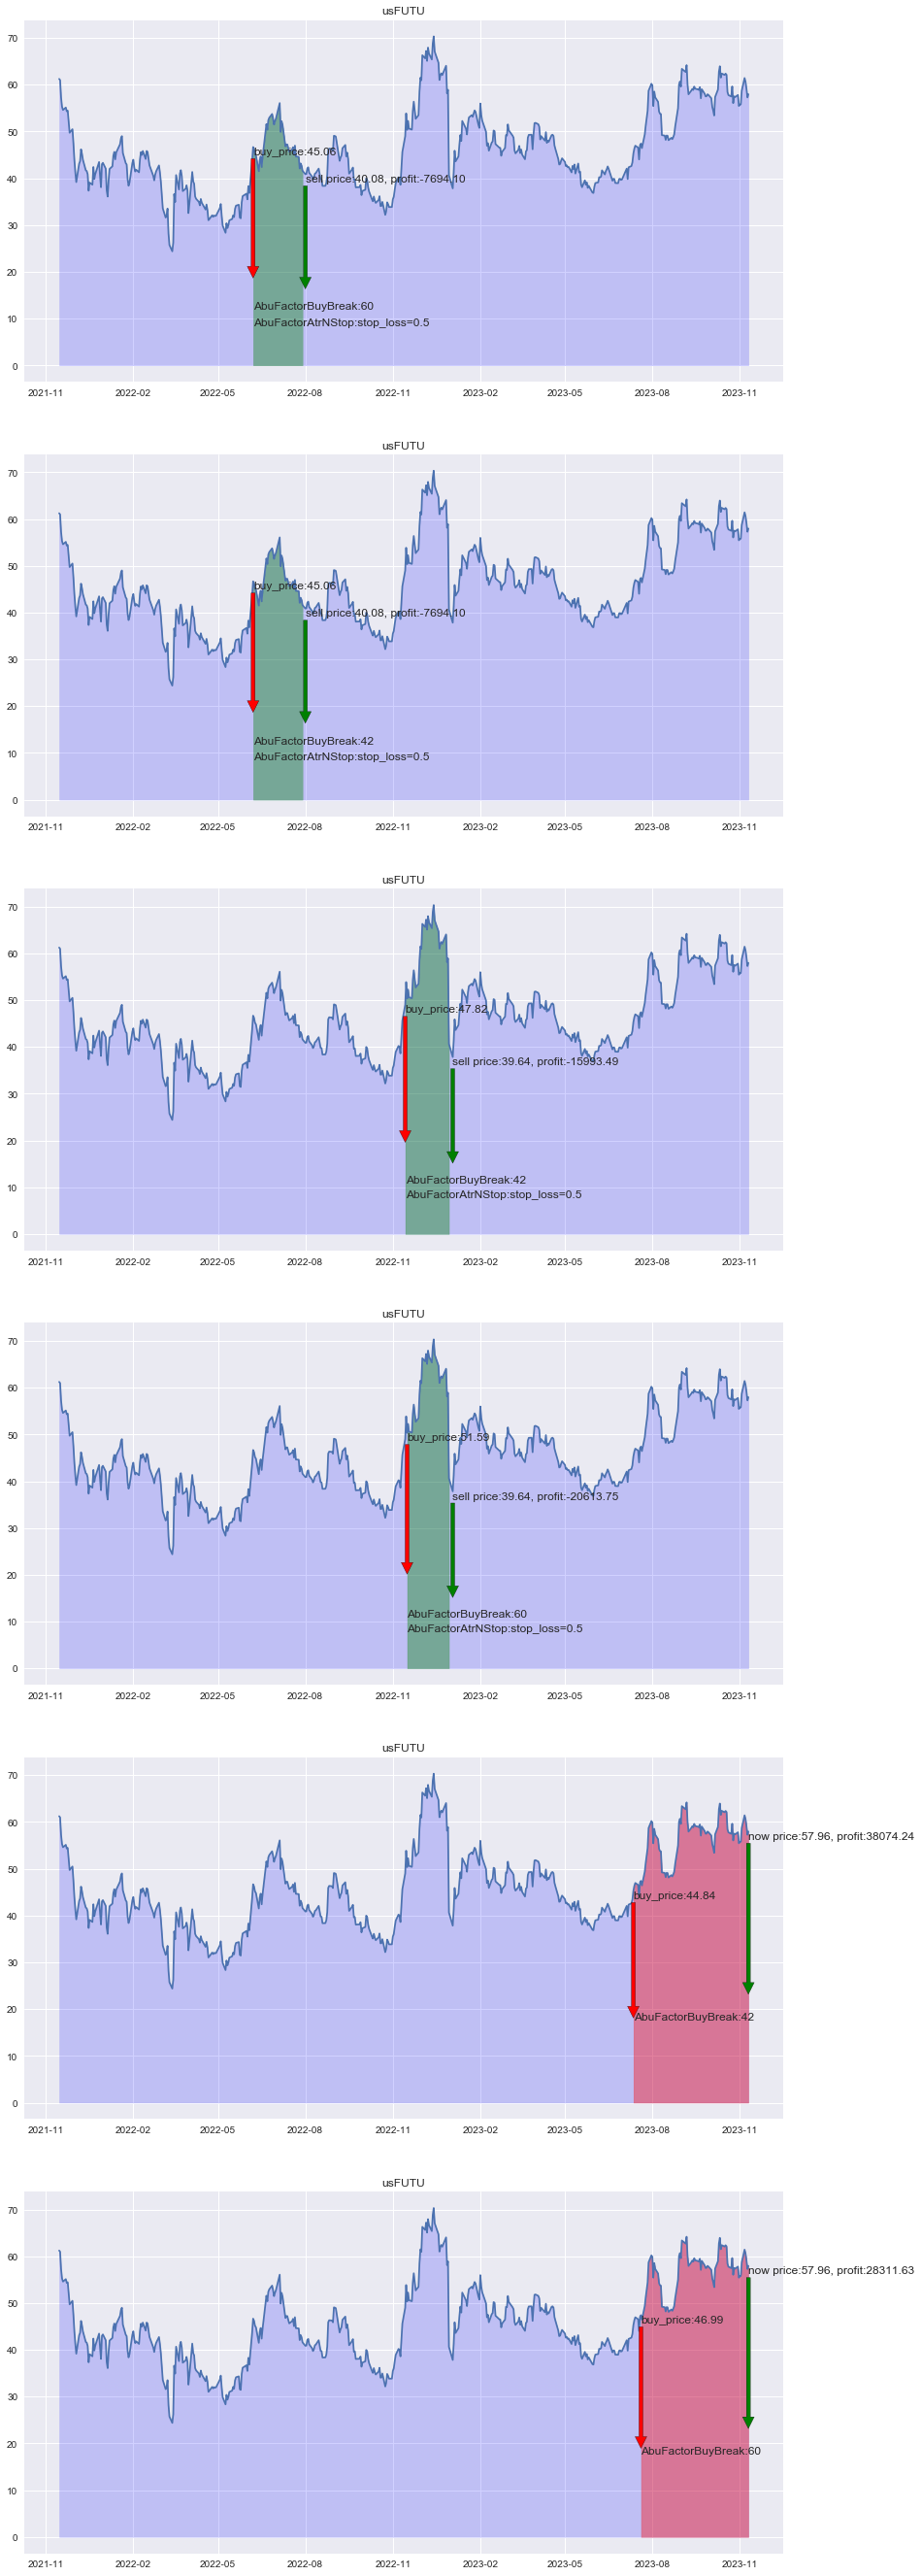

In [15]:
from abupy import AbuFactorAtrNStop
# 趋势跟踪策略止盈要大于止损设置值，这里0.5，3.0
sell_factor2 = {'stop_loss_n':0.5, 'stop_win_n':3.0, 'class': AbuFactorAtrNStop}
# 两个卖出因子策略并行同时生效
sell_factors = [sell_factor, sell_factor2]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usFUTU'], benchmark, buy_factors, sell_factors, capital, show=True)


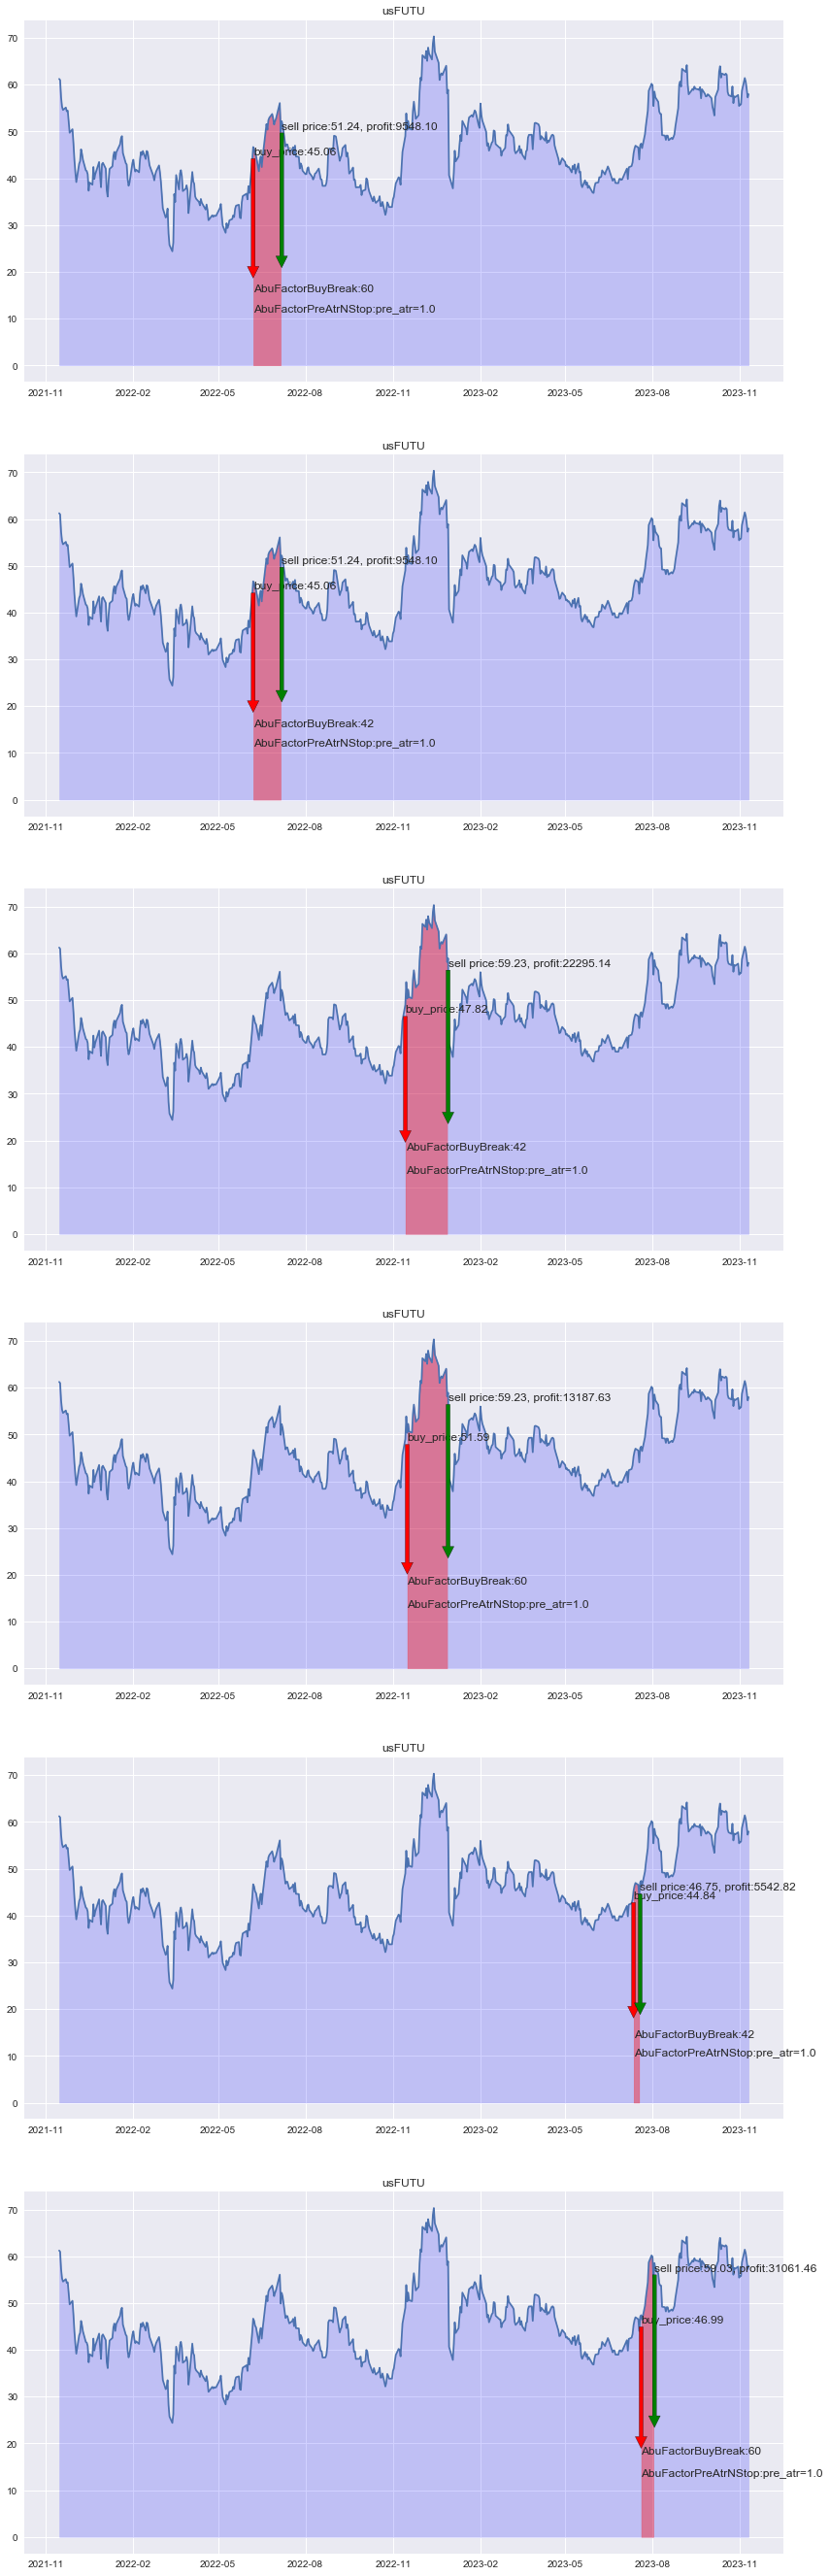

In [16]:
from abupy import AbuFactorPreAtrNStop
# 暴跌止损卖出因子形成dict
sell_factor3 =  {'class': AbuFactorPreAtrNStop, 'pre_atr_n':1.0}
# 三个卖出因子同时生效，组成sell_factors
sell_factors = [sell_factor, sell_factor2, sell_factor3]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usFUTU'], benchmark, buy_factors, sell_factors, capital, show=True)

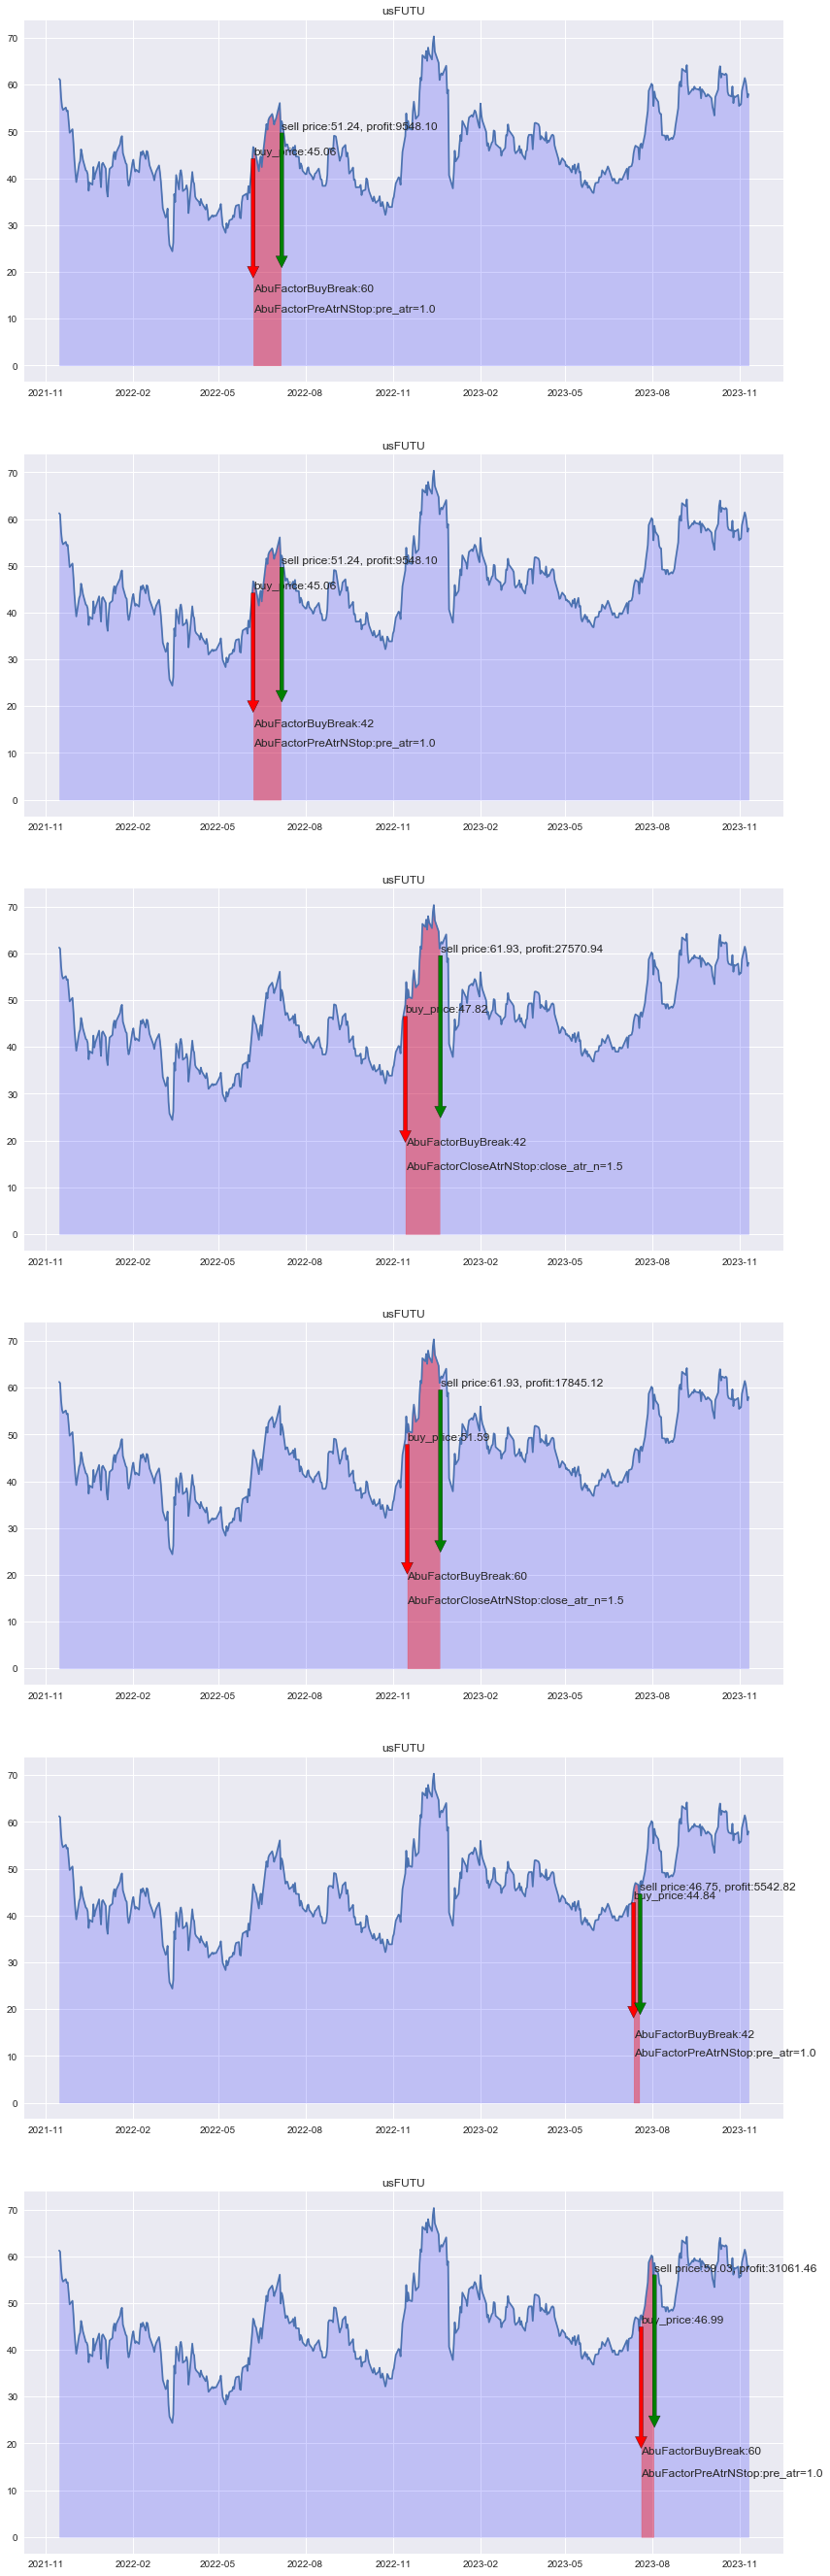

In [17]:
from abupy import AbuFactorCloseAtrNStop
# 保护止盈卖出因子组成dict
sell_factor4 = {'class': AbuFactorCloseAtrNStop, 'close_atr_n':1.5}
# 四个卖出因子同时并行生效
sell_factors = [sell_factor, sell_factor2, sell_factor3, sell_factor4]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usFUTU'], benchmark, buy_factors, sell_factors, capital, show=True)

### 8.1.3 滑点买入卖出价格确定以策略实现

In [18]:
from abupy import AbuSlippageBuyBase

# 修改g_open_down_rate的值为0.02
g_open_down_rate = 0.02

class AbuSlippageBuyMean2(AbuSlippageBuyBase):
    def fit_price(self):
        if (self.kl_pd_buy.open / self.kl_pd_buy.pre_close) < (
            1 - g_open_down_rate):
            # 开盘下跌K_OPEN_DOWN_RATE以上，单子失效
            print(self.factor_name + 'open down threshold')
            return np.inf
        # 买入价格为当天均价
        self.buy_price = np.mean(
            [self.kl_pd_buy['high'], self.kl_pd_buy['low']])
        return self.buy_price

AbuFactorBuyBreak:60open down threshold


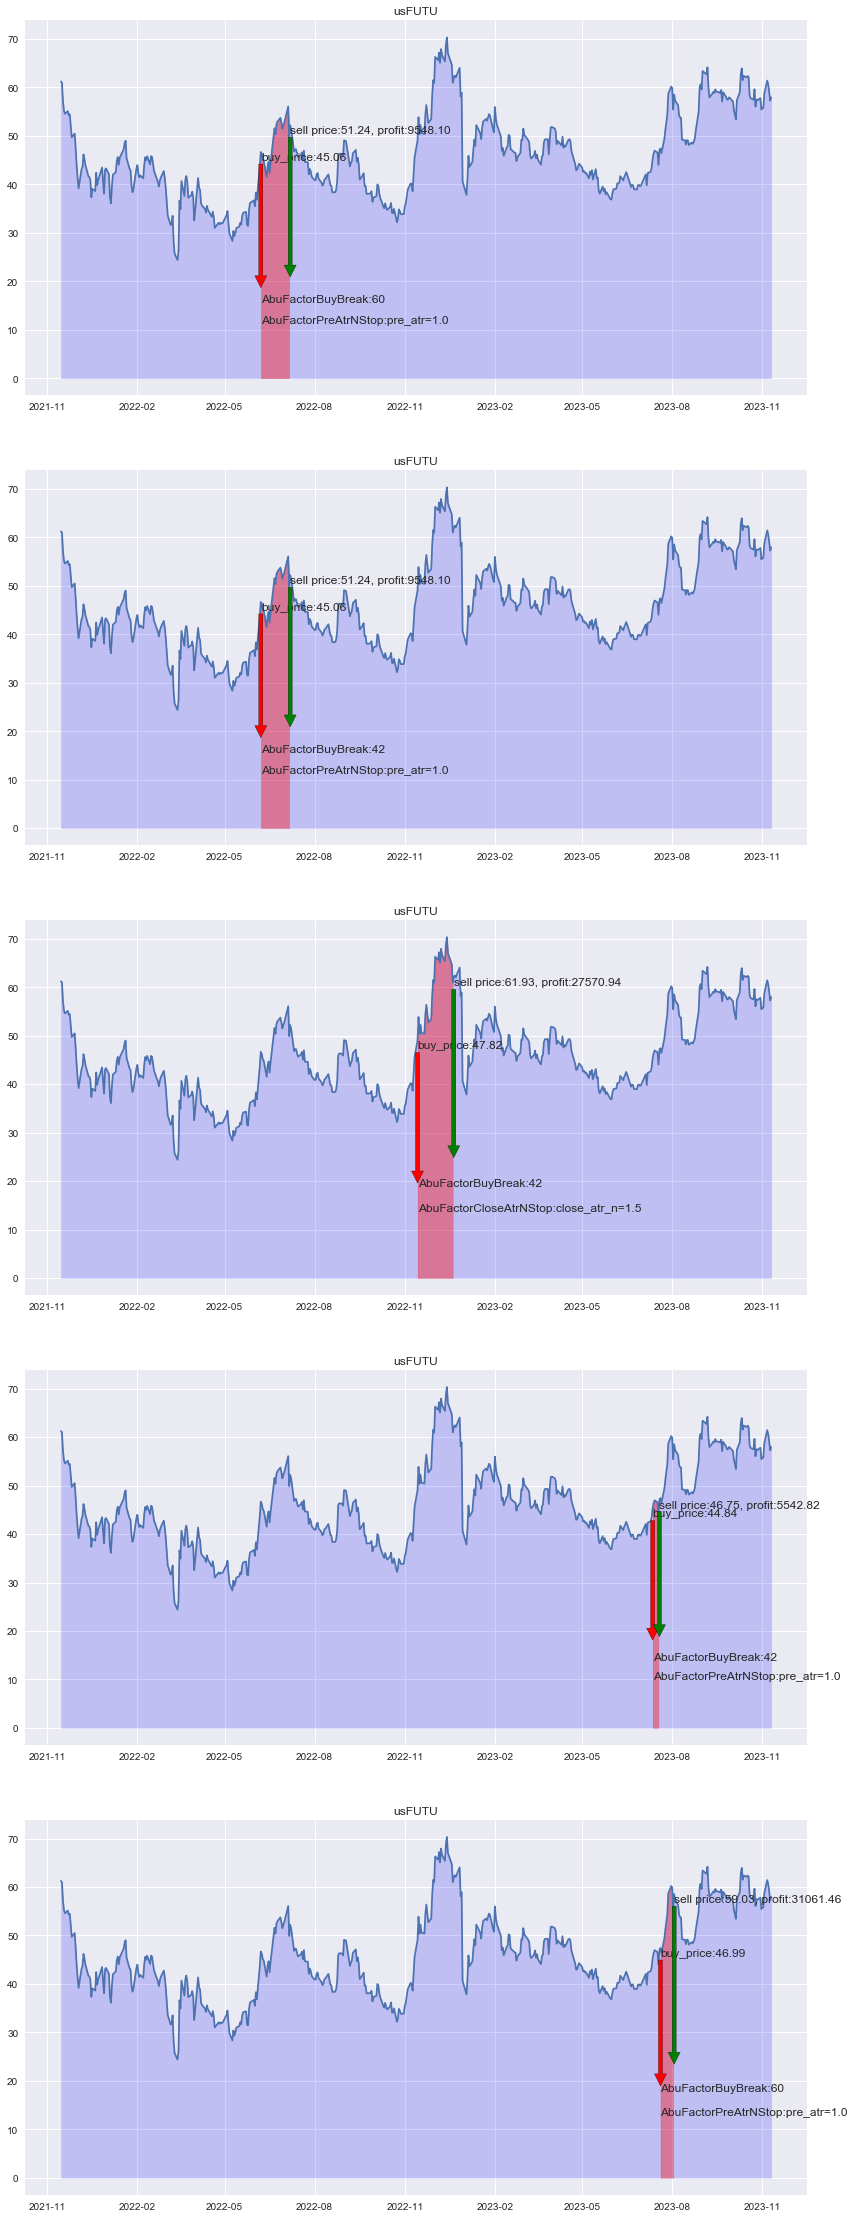

In [19]:
# 只针对60使用AbuSlippageBuyMean2
buy_factors2 = [{'slippage': AbuSlippageBuyMean2, 'xd': 60,
                 'class': AbuFactorBuyBreak},
                {'xd': 42, 'class': AbuFactorBuyBreak}]

sell_factors = [sell_factor, sell_factor2, sell_factor3,
                sell_factor4]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = \
    ABuPickTimeExecute.do_symbols_with_same_factors(['usFUTU'],
                                                    benchmark,
                                                    buy_factors2,
                                                    sell_factors,
                                                    capital,
                                                    show=True)

### 8.1.4 多只股票进行择时

In [31]:
# 我们假定choice_symbols是我们选股模块的结果，
choice_symbols = ['usFUTU', 'usTSLA']
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, all_fit_symbols_cnt = ABuPickTimeExecute.do_symbols_with_same_factors(choice_symbols, benchmark, buy_factors, sell_factors, capital, show=False)

capital.apply_action::3.57%

capital.apply_action::100.0%

In [32]:
orders_pd[:10].filter(['symbol', 'buy_price', 'buy_cnt', 'buy_factor', 'buy_pos', 
                       'sell_date', 'sell_type_extra', 'sell_type', 'profit'])

,symbol,buy_price,buy_cnt,buy_factor,buy_pos,sell_date,sell_type_extra,sell_type,profit
2022-03-23,usTSLA,1008.550,90.0,AbuFactorBuyBreak:42,AbuAtrPosition,20220411,AbuFactorCloseAtrNStop:close_atr_n=1.5,loss,-1529.55
2022-04-05,usTSLA,1120.085,106.0,AbuFactorBuyBreak:60,AbuAtrPosition,20220407,AbuFactorAtrNStop:stop_loss=0.5,loss,-7528.12
2022-06-07,usFUTU,45.060,1545.0,AbuFactorBuyBreak:60,AbuAtrPosition,20220707,AbuFactorPreAtrNStop:pre_atr=1.0,win,9548.10
2022-06-07,usFUTU,45.060,1545.0,AbuFactorBuyBreak:42,AbuAtrPosition,20220707,AbuFactorPreAtrNStop:pre_atr=1.0,win,9548.10
2022-07-22,usTSLA,827.250,126.0,AbuFactorBuyBreak:42,AbuAtrPosition,20220727,AbuFactorAtrNStop:stop_loss=0.5,loss,-2605.05
2022-08-02,usTSLA,900.750,120.0,AbuFactorBuyBreak:60,AbuAtrPosition,20220808,AbuFactorPreAtrNStop:pre_atr=1.0,loss,-1118.40
2022-11-14,usFUTU,47.820,1954.0,AbuFactorBuyBreak:42,AbuAtrPosition,20221221,AbuFactorCloseAtrNStop:close_atr_n=1.5,win,27570.94
2022-11-16,usFUTU,51.585,1725.0,AbuFactorBuyBreak:60,AbuAtrPosition,20221221,AbuFactorCloseAtrNStop:close_atr_n=1.5,win,17845.12
2023-02-06,usTSLA,194.045,438.0,AbuFactorBuyBreak:42,AbuAtrPosition,20230303,AbuFactorCloseAtrNStop:close_atr_n=1.5,win,1154.13
2023-02-08,usTSLA,198.655,475.0,AbuFactorBuyBreak:60,AbuAtrPosition,20230303,AbuFactorCloseAtrNStop:close_atr_n=1.5,loss,-938.12


In [33]:
action_pd[:10]

,Date,Price,Cnt,symbol,Direction,Price2,action,deal
0,20220323,1008.550,90.0,usTSLA,1.0,991.555,buy,True
1,20220405,1120.085,106.0,usTSLA,1.0,1049.065,buy,True
2,20220407,1049.065,106.0,usTSLA,1.0,1120.085,sell,True
3,20220411,991.555,90.0,usTSLA,1.0,1008.550,sell,True
4,20220607,45.060,1545.0,usFUTU,1.0,51.240,buy,True
5,20220607,45.060,1545.0,usFUTU,1.0,51.240,buy,True
6,20220707,51.240,1545.0,usFUTU,1.0,45.060,sell,True
7,20220707,51.240,1545.0,usFUTU,1.0,45.060,sell,True
8,20220722,827.250,126.0,usTSLA,1.0,806.575,buy,True
9,20220727,806.575,126.0,usTSLA,1.0,827.250,sell,True


买入后卖出的交易数量:14
买入后尚未卖出的交易数量:0
胜率:64.2857%
平均获利期望:16.5117%
平均亏损期望:-2.5108%
盈亏比:11.3461
策略收益: 14.3308%
基准收益: -13.4387%
策略年化收益: 7.2083%
基准年化收益: -6.7596%
策略买入成交比例:100.0000%
策略资金利用率比例:3.7761%
策略共执行501个交易日


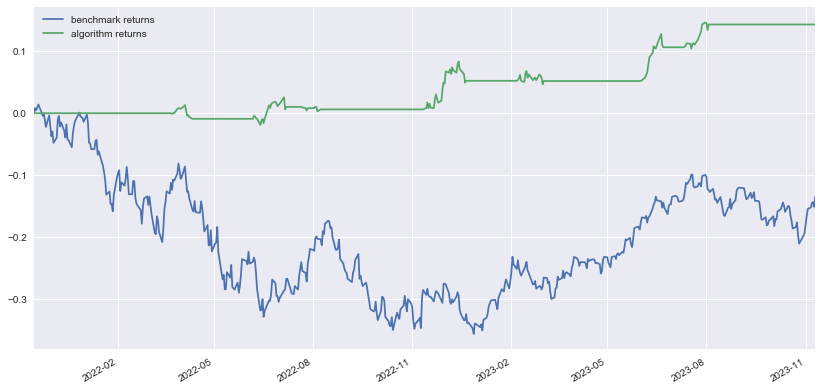

In [34]:
from abupy import AbuMetricsBase
metrics = AbuMetricsBase(orders_pd, action_pd, capital, benchmark)
metrics.fit_metrics()
metrics.plot_returns_cmp(only_show_returns=True)

### 8.1.5 自定义仓位管理策略的实现

In [35]:
metrics.gains_mean,  -metrics.losses_mean

(0.1651166373568281, 0.025107602159579162)

In [36]:
from abupy import AbuKellyPosition
buy_factors2 = [{'xd': 60, 'class': AbuFactorBuyBreak},
                {'xd': 42, 'position': {'class': AbuKellyPosition, 'win_rate': metrics.win_rate, 
                                        'gains_mean': metrics.gains_mean, 'losses_mean': -metrics.losses_mean},
                 'class': AbuFactorBuyBreak}]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, all_fit_symbols_cnt = ABuPickTimeExecute.do_symbols_with_same_factors(choice_symbols, benchmark, buy_factors2, sell_factors, capital, show=False)

capital.apply_action::3.57%

capital.apply_action::100.0%

In [37]:
orders_pd[:10].filter(['symbol', 'buy_cnt', 'buy_factor', 'buy_pos'])

,symbol,buy_cnt,buy_factor,buy_pos
2022-03-23,usTSLA,583.0,AbuFactorBuyBreak:42,AbuKellyPosition
2022-04-05,usTSLA,106.0,AbuFactorBuyBreak:60,AbuAtrPosition
2022-06-07,usFUTU,1545.0,AbuFactorBuyBreak:60,AbuAtrPosition
2022-06-07,usFUTU,13061.0,AbuFactorBuyBreak:42,AbuKellyPosition
2022-07-22,usTSLA,711.0,AbuFactorBuyBreak:42,AbuKellyPosition
2022-08-02,usTSLA,120.0,AbuFactorBuyBreak:60,AbuAtrPosition
2022-11-14,usFUTU,12307.0,AbuFactorBuyBreak:42,AbuKellyPosition
2022-11-16,usFUTU,1725.0,AbuFactorBuyBreak:60,AbuAtrPosition
2023-02-06,usTSLA,3033.0,AbuFactorBuyBreak:42,AbuKellyPosition
2023-02-08,usTSLA,475.0,AbuFactorBuyBreak:60,AbuAtrPosition
